In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer

In [2]:
#!pip install kaggle --upgrade
#!kaggle competitions download -c animal-shelter-logs
#!unzip animal-shelter-logs

In [3]:
df = pd.read_csv('train.csv')
df

,Name,SexuponOutcome,AnimalType,AgeuponOutcome,Breed,Color,DateTime,Outcome,ID
0,Socks,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Black/White,2014-06-11 14:36:00,0,0
1,Vera,Intact Female,Cat,1 month,Domestic Shorthair Mix,Tortie/White,2014-07-18 08:10:00,3,1
2,Biscuit,Neutered Male,Dog,3 months,Chihuahua Shorthair Mix,Yellow,2016-01-02 17:28:00,2,2
3,Kitten,Spayed Female,Cat,2 years,Domestic Shorthair Mix,Calico,2014-02-19 17:27:00,0,3
4,NaN,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Orange Tabby,2014-07-21 17:34:00,0,4
...,...,...,...,...,...,...,...,...,...
18705,Maverick,Neutered Male,Dog,7 months,Labrador Retriever Mix,Chocolate/White,2015-04-14 18:35:00,1,18705
18706,Thor,Intact Male,Dog,3 months,Pit Bull/Chihuahua Shorthair,Tan,2013-10-28 12:33:00,2,18706
18707,Roxy,Spayed Female,Dog,2 years,Pit Bull Mix,White/Brown Brindle,2014-12-05 15:14:00,0,18707
18708,NaN,Intact Male,Dog,2 years,Newfoundland Mix,Black,2014-06-29 17:08:00,1,18708


# Предобработка

#### ID и Name
    Игнорирование информации в данных столбцах за неимением статистической важной информации в них
#### SexuponOutcome
    Перевод в четыре столбца (два отвечают за пол, два за стерилизацию/нетронутость - нули в обоих значат unknown или NaN)
#### AnimalType
    Простая бинаризация: 0 - cat, 1 - dog
#### AgeuponOutcome
    1) Перевод в дни: 7 years = 7 лет = 7 * 365 дней
    (NaN, 0 years заменены на среднее значение дней по валидным записям)
    2) Берется логарифм от полученных значений для получения нормальной выборки
#### Breed
    1) Приведение в более компактный информативный вид:
        а) классы собак выделяются отдельно 
        (мастиф, дог, хаунд)
        б) национальные особенности написания переводятся на английский язык
        (dogo, italiano)
        в) приведение разных форм одного слова 
        (greater и great, spaniel и span) к одному значению
        г) приставка пропущенных слов 
        (akita (inu), imaal (terrier), pbgv = petit basset griffon verden)
        д) Грамматические приставки игнорируются 
    2) CountVectorizer для подсчёта уникальных слов в записи
    3) При наличии слэшей столбцы делятся на <число слэшей + 1> 
    (эффект смешанной породы - среднее значение вектора каждой породы)
    4) (неудачный приём, не используется) Отбор первых по упоминаемости признаков
    через return res[best]
#### Color
    Пункты (2-3) для Breed (аналогично, эффект смешанного цвета)
#### DateTime
    Перевод в численный вид
#### StandardScaling
    Перешкалирование Age (нормальное распределение) и 
    DateTime (равномерное распределение) к N(0,1)
#### Upsampling
    Искуственное раздувание подвыборок с outcome=2-4 до получения равномерного 
    распределения целевой переменной
    
#### Итог
    1) Пункт Breed_1 позволил убрать до 15 столбцов путём объединения равных по смыслу слов (+0.02 к метрике на сабмите)
    2) Upsampling оказал однозначно положительно влияние на обучение по всем используемым моделям, однако затруднило оценку переобучения модели (трейн подскочил аж на 0.3 при эффекте на сабмит 0.02-0.03)

In [4]:
def SexPreproc(df: pd.Series, model=None):
    df.fillna('Unknown', inplace=True)
    res = pd.DataFrame()
    res['Gender'] = df.apply(lambda x: x.split()[-1])
    res['Status'] = df.apply(lambda x: x.split()[0])
    res.loc[res['Status']=='Neutered','Status'] = 'Spayed'
    if model == None:
        model = OneHotEncoder(drop=['Unknown', 'Unknown'])
        model.fit(res)
    return pd.DataFrame(model.transform(res).toarray(), columns=model.get_feature_names_out()), model

def AnimalPreproc(df: pd.Series, model=None):
    res = np.array(df).reshape(-1,1)
    if model==None:
        model = LabelBinarizer()
        model.fit(df)
    return pd.DataFrame(data=model.transform(res), columns=['cat/dog']), model

def AgePreproc(df: pd.Series, filler=None):
    df.fillna('-1 days', inplace=True)
    res = pd.DataFrame()
    res['date_num'] = df.apply(lambda x: int(x.split()[0]))
    res['date_type'] = df.apply(lambda x: x.split()[1].rstrip('s'))
    df_period = res['date_num'] * res['date_type'].map({'month' : 30, 'year': 365, 'week': 7, 'day': 1})
    if filler == None:
        filler = df_period[df_period > 0].mean()
    df_period[df_period <= 0] = filler
    df_period.name = 'period'
    return np.log(df_period), filler

def BreedPreproc(df: pd.Series, model=None, best=None):
    clear = model==None
    df = df.apply(lambda x: x.lower()\
             .replace('dog', ' dog')\
             .replace('hound', ' hound')\
             .replace('mastiff', ' mastiff')\
             .replace('dogo', 'dog')\
             .replace('dogue', 'dog')\
             .replace('greater', 'great')\
             .replace('pbgv', 'petit basset griffon venden')
             .replace('italiano', 'italian')\
             .replace('havana', 'havanese')\
             .replace('bay retr', 'bay retriever')\
             .replace('terrier', 'terr')
             .replace('haired', ' hair')\
             .replace('hair', ' hair')\
             .replace('spaniel', 'span')\
             .replace('pinscher', ' pinsch')\
             .replace('pointing', 'pointer')\
             .replace('akita', 'akita inu')\
             .replace('imaal', 'imaal terr'))
    k_breeds = np.array(df.apply(lambda x: x.count('/')) + 1)
    if clear:
        model = CountVectorizer(stop_words=['de', 'st', 'of'])
        model.fit(df)
    res = pd.DataFrame(data=model.transform(df).toarray() / k_breeds.reshape(-1,1), columns=list(model.get_feature_names_out()))
    if clear:
        best = res.sum().sort_values(ascending=False)[:150].index
    return res, model, best

def ColorPreproc(df: pd.Series, model=None):
    if model==None:
        model = CountVectorizer()
        model.fit(df)
    k_colors = np.array(df.apply(lambda x: x.count('/')) + 1)
    res = pd.DataFrame(data=model.transform(df).toarray() / k_colors.reshape(-1,1), columns=list(model.get_feature_names_out()))
    return res, model

def DatePreproc(df: pd.Series):
    df_d = pd.to_numeric(pd.to_datetime(df))
    return df_d

def ReScale(df: pd.DataFrame, scaler=None):
    if scaler == None:
        scaler=StandardScaler()
    df_res = scaler.fit_transform(df)
    return df_res, scaler

def preprocessing(df: pd.DataFrame, models=None):
    if models == None:
        models = {'gender' : None, 'Animal': None,
                  'Age': None,'Breed': None, 'Best': None,
                  'Color': None,'Scaler': None}
    #обработка каждого столбца
    df_gen_bin, models['gender'] = SexPreproc(df['SexuponOutcome'], models['gender'])
    df_at, models['Animal'] = AnimalPreproc(df['AnimalType'], models['Animal'])
    df_period, models['Age'] = AgePreproc(df['AgeuponOutcome'], models['Age'])
    df_b, models['Breed'], models['Best'] = BreedPreproc(df['Breed'], models['Breed'], models['Best'])
    df_c, models['Color'] = ColorPreproc(df['Color'], models['Color'])
    df_d = DatePreproc(df['DateTime'])
    #объединение результатов предобработки по каждому столбцу
    #
    X = df_gen_bin.merge(df_at, left_index=True, right_index=True)\
    .merge(df_period, left_index=True, right_index=True)\
    .merge(df_b, left_index=True, right_index=True)\
    .merge(df_c, left_index=True, right_index=True)\
    .merge(df_d, left_index=True, right_index=True)
    #шкалирование
    X[['period', 'DateTime']], models['Scaler'] = ReScale(X[['period', 'DateTime']], models['Scaler'])
    y=None
    if 'Outcome' in df.columns:
        y = df.Outcome
        #up-sample
        X = pd.concat([X, *([X[y==2]] * 1), *([X[y==3]] * 5), *([X[y==4]] * 50)], ignore_index=True)
        y = pd.concat([y, *([y[y==2]] * 1), *([y[y==3]] * 5), *([y[y==4]] * 50)], ignore_index=True)
    return X,y,models

In [5]:
X,y,models = preprocessing(df)

In [6]:
X.shape

(34405, 270)

<AxesSubplot:>

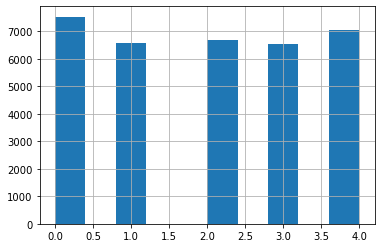

In [15]:
y.hist()

In [7]:
X.columns[6:100], X.columns[100:200], X.columns[200:237]

(Index(['abyssinian', 'affen', 'airedale', 'akita', 'alaskan', 'american',
        'anatol', 'angora', 'apso', 'argentino', 'australian', 'balinese',
        'basenji', 'basset', 'bay', 'beagle', 'beauceron', 'bedlington',
        'belgian', 'bengal', 'bernard', 'bernese', 'bichon', 'black_x', 'blood',
        'blue_x', 'bluetick', 'bobtail', 'boerboel', 'bombay', 'bordeaux',
        'border', 'boston', 'boxer', 'boykin', 'brindle_x', 'british',
        'brittany', 'brown_x', 'bruss', 'bull', 'burmese', 'cairn', 'canaan',
        'canario', 'cane', 'cardigan', 'carolina', 'catahoula', 'cattle',
        'cavalier', 'chesa', 'chihuahua', 'chin', 'chinese', 'chow', 'coat',
        'coated', 'cocker', 'collie', 'coon', 'corgi', 'cornish', 'corso',
        'crested', 'cur', 'dachshund', 'dalmatian', 'dane', 'devon', 'doberman',
        'dog', 'domestic', 'duck', 'dutch', 'english', 'eskimo', 'feist',
        'field', 'finnish', 'flat', 'fox', 'french', 'frise', 'german', 'giant',
        'g

In [9]:
test = pd.read_csv('test.csv')
test, _, _ = preprocessing(test, models)
test

,Gender_Female,Gender_Male,Status_Intact,Status_Spayed,cat/dog,period,abyssinian,affen,airedale,akita,...,tabby,tan_y,tick,tiger,torbie,tortie,tricolor,white,yellow,DateTime
0,1.0,0.0,1.0,0.0,0,-1.578521,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.992954
1,1.0,0.0,0.0,1.0,0,-0.701037,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.507999
2,0.0,1.0,0.0,1.0,0,-0.945517,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018370
3,0.0,1.0,0.0,1.0,0,-0.527575,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.131035
4,1.0,0.0,0.0,1.0,0,-0.945517,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.788962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,1.0,0.0,0.0,1.0,1,-0.109633,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.463578
8015,1.0,0.0,1.0,0.0,1,1.468008,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.201495
8016,0.0,1.0,0.0,1.0,1,0.805586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.001860
8017,0.0,1.0,1.0,0.0,0,-1.578521,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.391051


# Модели
    2 модели - логистическая регрессия и гистограммный градиентный бустинг

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 1234)

# LogReg
    1) Логистическая регрессия имела ограниченную успех в предсказании, в виду огромной размерности выборки
    2) Более того, регрессия не достигала сходимости даже при увеличении max_iter до 500)
    2) Попытки балансинга весов не оказали достаточного эффекта, эффект регуляризации был ограничен

In [37]:
params = {
    'C': [1, 5, 10],
    'class_weight': ['balanced', None],
}
model1 = LogisticRegression(max_iter=500, random_state=1234)
grid = GridSearchCV(LogisticRegression(), params, scoring=make_scorer(f1_score, average='macro'), cv=5)
grid.fit(X, y);

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [38]:
grid.best_params_, grid.best_score_

({'C': 10, 'class_weight': None}, 0.3978747228308211)

In [133]:
model1 = grid.best_estimator_
model1.fit(X_train, y_train)
f1_score(model1.predict(X_val), y_val, average='macro')

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.49098441195295467

# Gradboost
    Подбор гиперпараметров не смог помочь в достижении робастности модели (результатом грид сёрча был max_iter=200, max_depth=7, l2_reg = 1)
    P.S.: GridSearch выполнялся больше часа на colab, поэтому результаты о нём не были сохранены (всё равно не сработало))

In [ ]:
params = {
    max_iter=[50,100,150,200],
    max_depth=[3,5,7],
    'l2_regularization': [1, 2, 5],
}
model2 = GridSearchCV(HistGradientBoostingClassifier(random_state=1234), 
                      params, scoring=make_scorer(f1_score, average='macro'), cv=4)
model2.fit(X, y);

In [19]:
model2 = HistGradientBoostingClassifier(max_iter=200, max_depth=7, l2_regularization=10, random_state=1234)
model2.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=10, max_depth=7, max_iter=200,
                               random_state=1234)

Методом тыка сабмитов наилучшая модель взята при max_iter=200, max_depth=7, l2_regularization=10)

In [20]:
f1_score(model2.predict(X_val), y_val, average='micro'), f1_score(model2.predict(X_val), y_val, average='macro')

(0.7022235140241244, 0.6949645624458577)

# Result

In [22]:
model = model2
model.fit(X,y)
y_test = model.predict(test)
df_res = pd.DataFrame(data=y_test, columns=['Outcome'])
df_res.index.rename('ID', inplace=True)
df_res.to_csv('result.csv')

In [23]:
!kaggle competitions submit -c animal-shelter-logs -f result.csv -m "HistGradboost Reg 10 270 Better Upsample"

Successfully submitted to Animal Shelter Logs



  0%|          | 0.00/61.6k [00:00<?, ?B/s]
100%|##########| 61.6k/61.6k [00:00<00:00, 87.7kB/s]
